# Broccoli PIO NandIO simulation env

## Dev env


In [ ]:
# 初回だけ実行
# %pip install pandas
# %pip install wavedrom
# %pip install svgwrite
# %pip install rp2040-pio-emulator@git+https://github.com/NathanY3G/rp2040-pio-emulator
# %pip install adafruit-circuitpython-pioasm

## Sim + Analysis

Pythonを使ったデバッグ環境向け。このSectionの内容は最終的にProductに持っていく必要はない

In [1]:
from dataclasses import dataclass
import json
from typing import Any, Callable, Dict, List, Optional
import pandas as pd
from collections import deque
import itertools
import adafruit_pioasm
import pioemu
import wavedrom
import svgwrite


def to_hex_u32(x: int) -> str:
    """32bit符号なし整数を16進数文字列に変換する"""
    return f"0x{(x& 0xffffffff):08X}"


def to_hex_str_arr(src: List[int]) -> List[str]:
    return [to_hex_u32(x) for x in src]


@dataclass
class EmulateResult:
    """PIOのエミュレーション結果を格納するクラス"""

    program_str: str
    test_cycles: int
    tx_fifo_entries: List[int]
    run_states_df: pd.DataFrame
    event_df: pd.DataFrame
    rx_fifo: List[int]
    received_from_rx_fifo: List[int]
    wavedrom_src: str
    wave_svg: svgwrite.drawing.Drawing


def emulate_pio(
    program_str: str,
    test_cycles: int,
    tx_fifo_entries: List[int] = [],
    dequeue_period_cyc: int = 0,
) -> EmulateResult:
    """PIOのsimulationを行う"""

    # emulation
    opcodes = adafruit_pioasm.assemble(program_str)
    generator = pioemu.emulate(
        opcodes=opcodes,
        stop_when=lambda _, state: state.clock > test_cycles,
        input_source=lambda clock: ((clock // 2) & 0xFF)
        | (
            0x8000 if (((clock // 8) % 2) == 1) else 0x0000
        ),  # TestReadData = ClockCycle | RBB
        initial_state=pioemu.State(
            clock=0,
            program_counter=0,
            transmit_fifo=deque(tx_fifo_entries),
            receive_fifo=deque([]),
            x_register=0,
            y_register=0,
        ),
        shift_isr_right=False,
        shift_osr_right=True,
        side_set_count=5,
        side_set_base=10,
    )

    # run
    run_states = []
    received_data = []
    dma_dequeue_ready_cnt = 0  # dequeue_period_cycより大きければDequeue可能
    for before, after in itertools.islice(generator, test_cycles):
        run_states.append(after.__dict__)
        # dequeue
        dma_dequeue_ready_cnt += 1
        if (dma_dequeue_ready_cnt > dequeue_period_cyc) and (
            len(before.receive_fifo) > 0
        ):
            received_data.append(after.receive_fifo.popleft())
            dma_dequeue_ready_cnt = 0

    run_states_df = pd.DataFrame.from_records(run_states)
    rx_fifo = list(run_states_df[-1:]["receive_fifo"].values[0])

    # 欲しいデータ抽出

    def get_insert_idx() -> int:
        """DataFrameに新しい列を挿入するためのインデックスを返す"""

        dst = get_insert_idx.insert_idx  # increment前を返す
        get_insert_idx.insert_idx += 1
        return dst

    get_insert_idx.insert_idx = 0

    run_states_df.insert(
        get_insert_idx(),
        "cyc",
        run_states_df["clock"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "pc",
        run_states_df["program_counter"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "inst",
        run_states_df["pc"].map(lambda pc: to_hex_u32(opcodes[pc])),
    )
    run_states_df.insert(
        get_insert_idx(), "x", run_states_df["x_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "y", run_states_df["y_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "isr",
        run_states_df["input_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(),
        "osr",
        run_states_df["output_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(), "pindirs", run_states_df["pin_directions"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "pins", run_states_df["pin_values"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "io",
        run_states_df["pin_values"].map(
            lambda data: to_hex_u32((data & 0x000000FF) >> 0)
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "io_dir",
        run_states_df["pin_directions"].map(
            lambda data: to_hex_u32((data & 0x000000FF) >> 0)
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ceb0",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000100) >> 8),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ceb1",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000200) >> 9),
    )
    run_states_df.insert(
        get_insert_idx(),
        "cle",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000400) >> 10),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ale",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000800) >> 11),
    )
    run_states_df.insert(
        get_insert_idx(),
        "wpb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00001000) >> 12),
    )
    run_states_df.insert(
        get_insert_idx(),
        "web",
        run_states_df["pin_values"].map(lambda data: (data & 0x00002000) >> 13),
    )
    run_states_df.insert(
        get_insert_idx(),
        "reb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00004000) >> 14),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rbb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00008000) >> 15),
    )
    run_states_df.insert(
        get_insert_idx(),
        "txfifo_head",
        run_states_df["transmit_fifo"].map(
            lambda data: to_hex_u32(data[0]) if len(data) > 0 else None
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "txfifo_remain",
        run_states_df["transmit_fifo"].map(lambda data: len(data)),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rxfifo_tail",
        run_states_df["receive_fifo"].map(
            lambda data: to_hex_u32(data[-1]) if len(data) > 0 else None
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rxfifo_remain",
        run_states_df["receive_fifo"].map(lambda data: len(data)),
    )

    # シーケンス解析
    run_states_df["cs_assert"] = (run_states_df["ceb0"] == 0) | (
        run_states_df["ceb1"] == 0
    )
    # riseでNAND ICでキャプチャ想定
    run_states_df["web_edge"] = (run_states_df["web"] == 1) & (
        run_states_df.shift(1)["web"] == 0
    )
    # fallでICから出力、(t_rea遅れて) riseでPIOでキャプチャ想定。両方用意する
    run_states_df["reb_edge_nand"] = (run_states_df["reb"] == 0) & (
        run_states_df.shift(1)["reb"] == 1
    )
    run_states_df["reb_edge_pio"] = (run_states_df["reb"] == 1) & (
        run_states_df.shift(1)["reb"] == 0
    )
    run_states_df["reb_edge"] = run_states_df[
        "reb_edge_pio"
    ]  # PIOでrising edge時にキャプチャしたときの値で解析する

    run_states_df.insert(
        get_insert_idx(),
        "cmd_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 1)
        & (run_states_df["ale"] == 0),
    )
    run_states_df.insert(
        get_insert_idx(),
        "addr_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 1),
    )
    run_states_df.insert(
        get_insert_idx(),
        "data_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 0),
    )
    run_states_df.insert(
        get_insert_idx(),
        "data_out",
        run_states_df["reb_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["web"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 0),
    )

    # イベントだけを抽出しておく
    event_src = []
    for index, row in run_states_df.iterrows():
        event_type = None
        if row["cmd_in"]:
            event_type = "cmd_in"
        elif row["addr_in"]:
            event_type = "addr_in"
        elif row["data_in"]:
            event_type = "data_in"
        elif row["data_out"]:
            event_type = "data_out"
        else:
            continue
        event_src.append(
            {
                "cycle": row["cyc"],
                "pc": row["pc"],
                "event": event_type,
                "ceb0": row["ceb0"],
                "ceb1": row["ceb1"],
                "io": row["io"],
                "io_dir": row["io_dir"],
            }
        )
    event_df = pd.DataFrame.from_records(event_src)

    def to_wavedrom_signal(
        df: pd.DataFrame,
        col: str,
        replace_f: Optional[Callable[[Any, Any], Any]] = None,
    ) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].map(lambda x: "1" if x else "0").to_list()
        dst_wave = []

        prev_data = None
        for entry in src:
            # 差し替え関数あるなら任せる
            if replace_f is not None:
                dst_wave.append(replace_f(prev_data, entry))
            elif prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append(entry)
            # 一つ前のデータを保存
            prev_data = entry
        return {"name": col, "wave": "".join(dst_wave)}

    def to_wavedrom_data(df: pd.DataFrame, col: str) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].to_list()
        dst_wave = []
        dst_data = []

        prev_data = None
        for entry in src:
            # Noneのときは最初から一致してしまう
            if entry is None:
                dst_wave.append("x")
            elif prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append("=")
                dst_data.append(
                    hex(
                        int(entry, 16),
                    ).replace("0x", "")
                    if isinstance(entry, str)
                    else entry
                )  # 長いので縮める, str|intの場合分け
            # 一つ前のデータを保存
            prev_data = entry
        return {"name": col, "wave": "".join(dst_wave), "data": dst_data}

    wavedrom_src = json.dumps(
        {
            "signal": [
                [
                    "pio",
                    [
                        "ctrl",
                        to_wavedrom_data(run_states_df, "cyc"),
                        to_wavedrom_data(run_states_df, "pc"),
                        to_wavedrom_data(run_states_df, "inst"),
                        [
                            "fifo",
                            [
                                "tx",
                                to_wavedrom_data(run_states_df, "txfifo_head"),
                                to_wavedrom_data(run_states_df, "txfifo_remain"),
                            ],
                            [
                                "rx",
                                to_wavedrom_data(run_states_df, "rxfifo_tail"),
                                to_wavedrom_data(run_states_df, "rxfifo_remain"),
                            ],
                        ],
                    ],
                    {},
                    [
                        "regs",
                        [
                            "scratch",
                            to_wavedrom_data(run_states_df, "x"),
                            to_wavedrom_data(run_states_df, "y"),
                        ],
                        [
                            "fifo",
                            to_wavedrom_data(run_states_df, "isr"),
                            to_wavedrom_data(run_states_df, "osr"),
                        ],
                        [
                            "pinout",
                            to_wavedrom_data(run_states_df, "pindirs"),
                            to_wavedrom_data(run_states_df, "pins"),
                        ],
                    ],
                ],
                {},
                [
                    "nand",
                    [
                        "out",
                        [
                            "cs",
                            to_wavedrom_signal(run_states_df, "ceb0"),
                            to_wavedrom_signal(run_states_df, "ceb1"),
                        ],
                        [
                            "latch",
                            to_wavedrom_signal(run_states_df, "cle"),
                            to_wavedrom_signal(run_states_df, "ale"),
                        ],
                        [
                            "edge",
                            to_wavedrom_signal(run_states_df, "web"),
                            to_wavedrom_signal(run_states_df, "reb"),
                        ],
                        to_wavedrom_signal(run_states_df, "wpb"),
                    ],
                    {},
                    [
                        "inout",
                        to_wavedrom_data(run_states_df, "io"),
                        to_wavedrom_data(run_states_df, "io_dir"),
                    ],
                    {},
                    [
                        "in",
                        to_wavedrom_signal(run_states_df, "rbb"),
                    ],
                    {},
                    [
                        "analysis",
                        [
                            "src",
                            to_wavedrom_signal(run_states_df, "cs_assert"),
                            to_wavedrom_signal(run_states_df, "web_edge"),
                            to_wavedrom_signal(run_states_df, "reb_edge"),
                        ],
                        [
                            "event",
                            to_wavedrom_signal(run_states_df, "cmd_in"),
                            to_wavedrom_signal(run_states_df, "addr_in"),
                            to_wavedrom_signal(run_states_df, "data_in"),
                            to_wavedrom_signal(run_states_df, "data_out"),
                        ],
                    ],
                ],
            ]
        }
    )
    wave_svg = wavedrom.render(wavedrom_src)

    return EmulateResult(
        program_str=program_str,
        test_cycles=test_cycles,
        tx_fifo_entries=tx_fifo_entries,
        run_states_df=run_states_df,
        event_df=event_df,
        rx_fifo=rx_fifo,
        received_from_rx_fifo=received_data,
        wavedrom_src=wavedrom_src,
        wave_svg=wave_svg,
    )

## NAND IC + PIO Program Definition

実機に移植が必要な部分

In [12]:
from typing import List, Optional, Union
import pandas as pd
from enum import Enum, auto
from IPython.display import display
from pathlib import Path
import pandas as pd

#################################################
# NAND ICで決められた定義


class NandPinAssign(int, Enum):
    """
    NAND IC Pinout
    | 15  | 14  | 13  | 12  | 11  | 10  | 9    | 8    | 7   | 6   | 5   | 4   | 3   | 2   | 1   | 0   |
    | --- | --- | --- | --- | --- | --- | ---- | ---- | --- | --- | --- | --- | --- | --- | --- | --- |
    | rbb | reb | web | wpb | ale | cle | ceb1 | ceb0 | io7 | io6 | io5 | io4 | io3 | io2 | io1 | io0 |
    | in  | out | out | out | out | out | out  | out  | io  | io  | io  | io  | io  | io  | io  | io  |
    """

    Io0 = 0
    Io1 = 1
    Io2 = 2
    Io3 = 3
    Io4 = 4
    Io5 = 5
    Io6 = 6
    Io7 = 7
    Ceb0 = 8
    Ceb1 = 9
    Cle = 10
    Ale = 11
    Wpb = 12
    Web = 13
    Reb = 14
    Rbb = 15

def bit_on(bit_pos: int) -> int:
    """指定したbitだけ1の値"""
    return 0x01 << bit_pos


def combine_halfword(low: int, high: int) -> int:
    """2byteの値を結合する"""
    return (high << 16) | low


def gen_ceb_bits(select_cs: Optional[int] = None) -> int:
    """cs指定からCEB0/CEB1のピン状態を返す"""
    if select_cs is None:
        return bit_on(NandPinAssign.Ceb0.value) | bit_on(NandPinAssign.Ceb1.value)
    elif select_cs == 0:
        return bit_on(NandPinAssign.Ceb1.value)
    elif select_cs == 1:
        return bit_on(NandPinAssign.Ceb0.value)
    else:
        raise ValueError("select_cs must be 0 or 1 or None")


# RBB以外全部Output
write_pin_dir = (
    bit_on(NandPinAssign.Reb.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Ale.value)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Ceb1.value)
    | bit_on(NandPinAssign.Ceb0.value)
    | bit_on(NandPinAssign.Io7.value)
    | bit_on(NandPinAssign.Io6.value)
    | bit_on(NandPinAssign.Io5.value)
    | bit_on(NandPinAssign.Io4.value)
    | bit_on(NandPinAssign.Io3.value)
    | bit_on(NandPinAssign.Io2.value)
    | bit_on(NandPinAssign.Io1.value)
    | bit_on(NandPinAssign.Io0.value)
)

# RBB,IO以外Output
read_pin_dir = (
    bit_on(NandPinAssign.Reb.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Wpb.value)
    | bit_on(NandPinAssign.Ale.value)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Ceb1.value)
    | bit_on(NandPinAssign.Ceb0.value)
)


# 単一コマンド、DataListへのCSセット用
def bitor_cs(
    data_src: Union[int, List[int]], select_cs: Optional[int]
) -> Union[int, List[int]]:
    """data_srcに対して、csを指定してCEB0/CEB1をセットする。単一変数・リストどちらでも対応"""
    if isinstance(data_src, int):
        return gen_ceb_bits(select_cs) | data_src
    else:
        return [gen_ceb_bits(select_cs) | data for data in data_src]


def gen_addressing(column_addr: int, page_addr: int, block_addr: int) -> List[int]:
    """アドレスをNAND Flashの指定フォーマットに変換する。Schematic Cell Layout and Address Assignment参照

    |              | I/O7 | I/O6 | I/O5 | I/O4 | I/O3 | I/O2 | I/O1 | I/O0 |
    | -------------|------|------|------|------|------|------|------|------|
    | First  cycle | CA7  | CA6  | CA5  | CA4  | CA3  | CA2  | CA1  | CA0  |
    | Second cycle | L    | L    | L    | L    | CA11 | CA10 | CA9  | CA8  |
    | Third  cycle | PA7  | PA6  | PA5  | PA4  | PA3  | PA2  | PA1  | PA0  |
    | Fourth cycle | PA15 | PA14 | PA13 | PA12 | PA11 | PA10 | PA9  | PA8  |

    - CA0 to CA11: Column address
    - PA0 to PA5: Page address in block
    - PA6 to PA15: Block address
    """
    ca = column_addr & 0xFFF
    pa = (page_addr & 0x3F) | ((block_addr & 0x3ff) << 6)
    return [
        ca & 0xFF,
        (ca >> 8) & 0x0F,
        pa & 0xFF,
        (pa >> 8) & 0xFF,
    ]

def gen_addressing_block(block_addr: int) -> List[int]:
    """Block Addressを2byteのAddressInput用に変換する。Auto Block Erase用。"""
    return [
        block_addr & 0xFF,
        (block_addr >> 8) & 0xFF,
    ]


#################################################
# broccoli nandio 独自の定義


class BroccoliNandIoCommand(int, Enum):
    """Broccoli NAND IO Command"""

    Bitbang = 0x00
    CmdLatch = 0x01
    AddrLatch = 0x02
    DataOutput = 0x03
    DataInput = 0x04
    SetIrq = 0x05
    WaitRbb = 0x06

    def gen_cmd_header(
        self, pindirs: int, transfer_count: int, arg0: Optional[int]
    ) -> List[int]:
        """コマンドの先頭wordを返す. RShiftで取り出す想定. transfer_countに実際にセットされる値は、pio都合で-1される。"""
        return [
            # cmd_0 = { cmd_id[3:0], transfer_count[11:0], pindirs[15:0] }
            ((self.value & 0xF) << 28)
            | ((((transfer_count - 1) & 0x0FFF) << 16) | (pindirs & 0xFFFF)),
            # arg_0 = { arg0[31:0] }
            arg0 if arg0 is not None else 0x00000000,
        ]


def sim_broccoli(
    tx_fifo_entries: List[int],
    export_file_name: Optional[str] = None,
    test_cycles: int = 150,
    dequeue_period_cyc: int = 16,
) -> EmulateResult:
    """デバッグ用。Simの実行と結果表示を行う"""

    # PIO Assembler
    program = Path("broccoli-pio-nandio.pio").read_text(encoding="utf-8")
    result = emulate_pio(
        program,
        test_cycles=test_cycles,
        tx_fifo_entries=tx_fifo_entries,
        dequeue_period_cyc=dequeue_period_cyc,
    )

    pd.set_option("display.max_rows", 100)
    pd.set_option("display.max_columns", 100)

    # output logs
    if export_file_name is not None:
        Path("dst").mkdir(exist_ok=True)
        Path(f"dst/{export_file_name}").mkdir(exist_ok=True)
        Path(f"dst/{export_file_name}/broccoli-pio-nandio.pio").write_text(
            program, encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/tx_fifo.json").write_text(
            json.dumps(result.tx_fifo_entries), encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/rx_fifo.json").write_text(
            json.dumps(result.rx_fifo), encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/wave.json").write_text(result.wavedrom_src)
        result.run_states_df.to_csv(f"dst/{export_file_name}/run_states.csv")
        result.event_df.to_csv(f"dst/{export_file_name}/event.csv")
        result.wave_svg.saveas(f"dst/{export_file_name}/wave.svg")

    print(
        f"tx_fifo_entries: {len(result.tx_fifo_entries)} {to_hex_str_arr(result.tx_fifo_entries)}"
    )
    print(f"received_from_rx_fifo: {to_hex_str_arr(result.received_from_rx_fifo)}")
    print(f"rx_fifo: {to_hex_str_arr(result.rx_fifo)}")
    display(result.event_df)
    display(result.wave_svg)
    display(result.run_states_df)

    return result

----

# Command Debug

pio の TX/RX Fifoにデータを流し込む想定シーケンスを動かしてみる。部分的にProductへの移植が必要になると思われる

In [3]:

class NandFlashCommand(Enum):
    """NAND Flash Command"""

    SerialDataInput = 0x80
    Read1stCycle = 0x00
    Read2ndCycle = 0x30
    ReadWithDataCache = 0x31
    ReadStartForLastPageInReadCycleWithDataCache = 0x3F
    AutoPageProgram1stCycle = 0x80
    AutoPageProgram2ndCycle = 0x10
    ColumnAddressChangeInSerialDataInput = 0x85
    AutoPageProgramWithDataCache1stCycle = 0x80
    AutoPageProgramWithDataCache2ndCycle = 0x15
    ReadForPageCopyWithDataOut1stCycle = 0x00
    ReadForPageCopyWithDataOut2ndCycle = 0x3A
    AutoProgramWithDataCacheDuringPageCopy1stCycle = 0x8C
    AutoProgramWithDataCacheDuringPageCopy2ndCycle = 0x15
    AutoProgramForLastPageDuringPageCopy1stCycle = 0x8C
    AutoProgramForLastPageDuringPageCopy2ndCycle = 0x10
    AutoBlockErase1stCycle = 0x60
    AutoBlockErase2ndCycle = 0xD0
    ReadId = 0x90
    StatusRead = 0x70
    Reset = 0xFF


### Auto Block Erase

address_list: ['0x00000021', '0x00000003']
tx_fifo_entries: 22 ['0x0FFF6FFF', '0x00000300', '0x0FFF6FFF', '0x00000200', '0x10006FFF', '0x00000260', '0x20016FFF', '0x00000000', '0x00000221', '0x00000203', '0x10006FFF', '0x000002D0', '0x6FFF6FFF', '0x00000000', '0x10006FFF', '0x00000270', '0x30007F00', '0x00000000', '0x0FFF6FFF', '0x00000300', '0x5FFF6FFF', '0x00000000']
received_from_rx_fifo: ['0x00000029']
rx_fifo: []


cycle  pc     event  ceb0  ceb1          io      io_dir
0     26   0    cmd_in     0     1  0x00000060  0x000000FF
1     37  13   addr_in     0     1  0x00000021  0x000000FF
2     40  16   addr_in     0     1  0x00000003  0x000000FF
3     51   0    cmd_in     0     1  0x000000D0  0x000000FF
4     72   0    cmd_in     0     1  0x00000070  0x000000FF
5     84  21  data_out     0     1  0x00000029  0x00000000

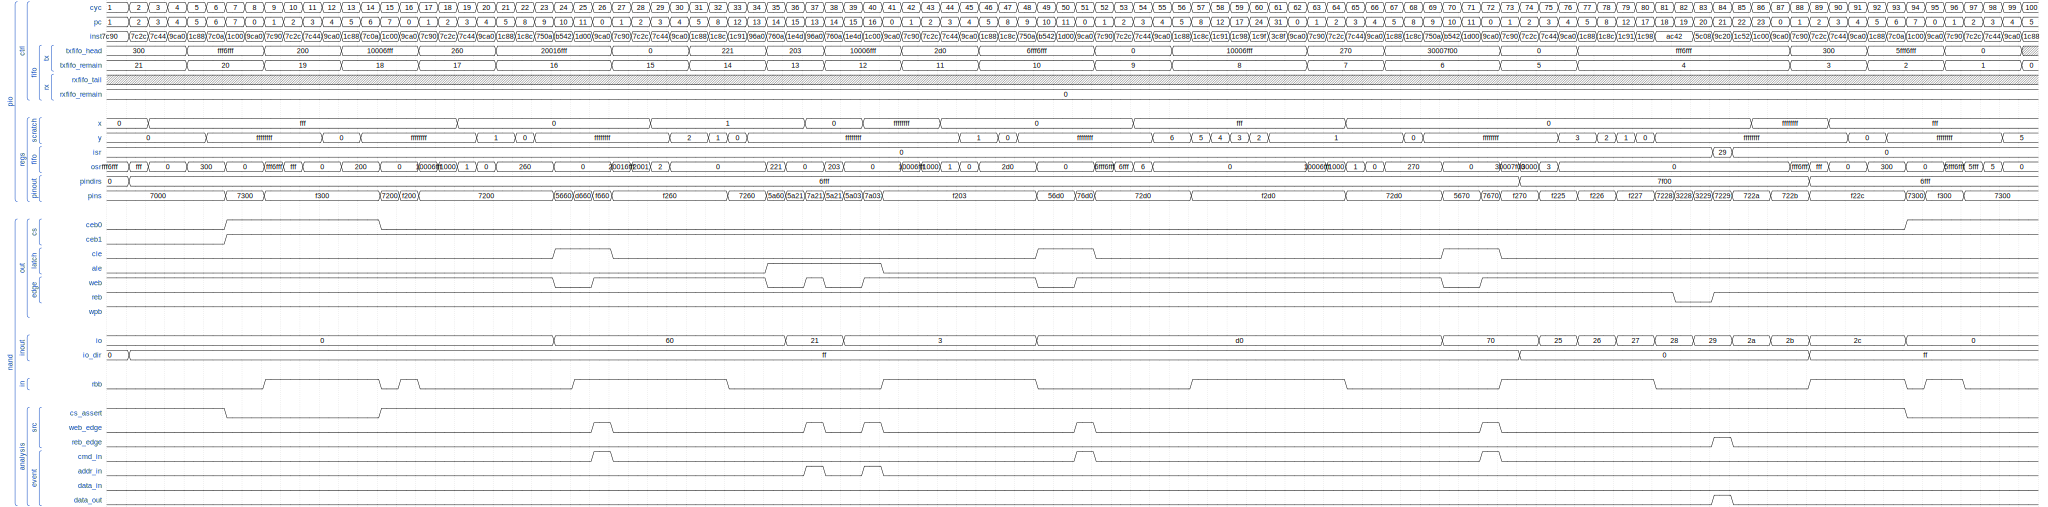

cyc  pc        inst           x           y         isr         osr  \
0     1   1  0x00007C90  0x00000000  0x00000000  0x00000000  0x0FFF6FFF   
1     2   2  0x00007C2C  0x00000000  0x00000000  0x00000000  0x00000FFF   
2     3   3  0x00007C44  0x00000FFF  0x00000000  0x00000000  0x00000000   
3     4   4  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
4     5   5  0x00001C88  0x00000FFF  0x00000000  0x00000000  0x00000300   
5     6   6  0x00007C0A  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000300   
6     7   7  0x00001C00  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000000   
7     8   0  0x00009CA0  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000000   
8     9   1  0x00007C90  0x00000FFF  0xFFFFFFFF  0x00000000  0x0FFF6FFF   
9    10   2  0x00007C2C  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000FFF   
10   11   3  0x00007C44  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000000   
11   12   4  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
12   13   5  0x00001C88  0x00000FFF  0x00000000  0x00000000  0x00000200   
13   14   6  0x00007C0A  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000200   
14   15   7  0x00001C00  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000000   
15   16   0  0x00009CA0  0x00000FFF  0xFFFFFFFF  0x00000000  0x00000000   
16   17   1  0x00007C90  0x00000FFF  0xFFFFFFFF  0x00000000  0x10006FFF   
17   18   2  0x00007C2C  0x00000FFF  0xFFFFFFFF  0x00000000  0x00001000   
18   19   3  0x00007C44  0x00000000  0xFFFFFFFF  0x00000000  0x00000001   
19   20   4  0x00009CA0  0x00000000  0x00000001  0x00000000  0x00000000   
20   21   5  0x00001C88  0x00000000  0x00000001  0x00000000  0x00000260   
21   22   8  0x00001C8C  0x00000000  0x00000000  0x00000000  0x00000260   
22   23   9  0x0000750A  0x00000000  0xFFFFFFFF  0x00000000  0x00000260   
23   24  10  0x0000B542  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
24   25  11  0x00001D00  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
25   26   0  0x00009CA0  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
26   27   1  0x00007C90  0x00000000  0xFFFFFFFF  0x00000000  0x20016FFF   
27   28   2  0x00007C2C  0x00000000  0xFFFFFFFF  0x00000000  0x00002001   
28   29   3  0x00007C44  0x00000001  0xFFFFFFFF  0x00000000  0x00000002   
29   30   4  0x00009CA0  0x00000001  0x00000002  0x00000000  0x00000000   
30   31   5  0x00001C88  0x00000001  0x00000002  0x00000000  0x00000000   
31   32   8  0x00001C8C  0x00000001  0x00000001  0x00000000  0x00000000   
32   33  12  0x00001C91  0x00000001  0x00000000  0x00000000  0x00000000   
33   34  13  0x000096A0  0x00000001  0xFFFFFFFF  0x00000000  0x00000000   
34   35  14  0x0000760A  0x00000001  0xFFFFFFFF  0x00000000  0x00000221   
35   36  15  0x00001E4D  0x00000001  0xFFFFFFFF  0x00000000  0x00000000   
36   37  13  0x000096A0  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
37   38  14  0x0000760A  0x00000000  0xFFFFFFFF  0x00000000  0x00000203   
38   39  15  0x00001E4D  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
39   40  16  0x00001C00  0xFFFFFFFF  0xFFFFFFFF  0x00000000  0x00000000   
40   41   0  0x00009CA0  0xFFFFFFFF  0xFFFFFFFF  0x00000000  0x00000000   
41   42   1  0x00007C90  0xFFFFFFFF  0xFFFFFFFF  0x00000000  0x10006FFF   
42   43   2  0x00007C2C  0xFFFFFFFF  0xFFFFFFFF  0x00000000  0x00001000   
43   44   3  0x00007C44  0x00000000  0xFFFFFFFF  0x00000000  0x00000001   
44   45   4  0x00009CA0  0x00000000  0x00000001  0x00000000  0x00000000   
45   46   5  0x00001C88  0x00000000  0x00000001  0x00000000  0x000002D0   
46   47   8  0x00001C8C  0x00000000  0x00000000  0x00000000  0x000002D0   
47   48   9  0x0000750A  0x00000000  0xFFFFFFFF  0x00000000  0x000002D0   
48   49  10  0x0000B542  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
49   50  11  0x00001D00  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
50   51   0  0x00009CA0  0x00000000  0xFFFFFFFF  0x00000000  0x00000000   
51   52   1  0x00007C90  0x00000000  0xFFFFFFFF  0x00000000  0x6FFF6FFF   
52   53   2  0x00007C2C  0x00

In [14]:
select_cs = 0
block_addr = 0x321
address_list = gen_addressing_block(block_addr=block_addr)

print(f"address_list: {to_hex_str_arr(address_list)}")

tx_fifo_entries = list(
    itertools.chain.from_iterable(
        [
            #############################################
            ### init pin (=negate cs) ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### assert cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=select_cs)
            ),
            #############################################
            ### CMD: Auto Block Erase ###
            # cmd: 0x60
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.AutoBlockErase1stCycle.value, select_cs=select_cs),
            ),
            # block addr (2cycle)
            BroccoliNandIoCommand.AddrLatch.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=2, arg0=None
            ),
            bitor_cs(address_list, select_cs=select_cs),
            # cmd: 0xD0
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.AutoBlockErase2ndCycle.value, select_cs=select_cs),
            ),
            #############################################
            ### wait RBB ###
            BroccoliNandIoCommand.WaitRbb.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
            #############################################
            ### Status Read ###
            # cmd: 0x70
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.StatusRead.value, select_cs=select_cs),
            ),
            # read status output
            BroccoliNandIoCommand.DataOutput.gen_cmd_header(
                pindirs=read_pin_dir, transfer_count=1, arg0=None
            ),
            #############################################
            ### negate cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### set IRQ ###
            BroccoliNandIoCommand.SetIrq.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
        ]
    )
)

ret = sim_broccoli(tx_fifo_entries=tx_fifo_entries, export_file_name="auto_block_erase", test_cycles=100, dequeue_period_cyc=4)
# verify
# cmd=autoblockerase1st
assert(ret.event_df.iloc[0]["event"] == "cmd_in")
assert(ret.event_df.iloc[0]["io"] == to_hex_u32(NandFlashCommand.AutoBlockErase1stCycle.value))
assert(ret.event_df.iloc[0]["io_dir"] == to_hex_u32(0xff))
# addr(block 2byte)
assert(ret.event_df.iloc[1]["event"] == "addr_in")
assert(ret.event_df.iloc[2]["event"] == "addr_in")
assert(ret.event_df.iloc[1]["io"] == to_hex_u32(address_list[0]))
assert(ret.event_df.iloc[2]["io"] == to_hex_u32(address_list[1]))
assert(ret.event_df.iloc[1]["io_dir"] == to_hex_u32(0xff))
assert(ret.event_df.iloc[2]["io_dir"] == to_hex_u32(0xff))
# cmd=autoblockerase2nd
assert(ret.event_df.iloc[3]["event"] == "cmd_in")
assert(ret.event_df.iloc[3]["io"] == to_hex_u32(NandFlashCommand.AutoBlockErase2ndCycle.value))
assert(ret.event_df.iloc[3]["io_dir"] == to_hex_u32(0xff))
# cmd=statusread
assert(ret.event_df.iloc[4]["event"] == "cmd_in")
assert(ret.event_df.iloc[4]["io"] == to_hex_u32(NandFlashCommand.StatusRead.value))
assert(ret.event_df.iloc[4]["io_dir"] == to_hex_u32(0xff))
# status output
assert(ret.event_df.iloc[5]["event"] == "data_out")
assert(ret.event_df.iloc[5]["io_dir"] == to_hex_u32(0x00)) # input
assert(ret.event_df.iloc[5]["io"] == to_hex_u32(ret.received_from_rx_fifo[0])) # status output



### Auto Page Program

address_list: ['0x00000021', '0x00000003', '0x00000094', '0x0000001D']
data_list: ['0x000000FF', '0x000000FE', '0x000000FD', '0x000000FC', '0x000000FB', '0x000000FA', '0x000000F9', '0x000000F8']
tx_fifo_entries: 34 ['0x0FFF6FFF', '0x00000300', '0x0FFF6FFF', '0x00000200', '0x10006FFF', '0x00000280', '0x20036FFF', '0x00000000', '0x00000221', '0x00000203', '0x00000294', '0x0000021D', '0x40076FFF', '0x00000000', '0x000002FF', '0x000002FE', '0x000002FD', '0x000002FC', '0x000002FB', '0x000002FA', '0x000002F9', '0x000002F8', '0x10006FFF', '0x00000210', '0x6FFF6FFF', '0x00000000', '0x10006FFF', '0x00000270', '0x30007F00', '0x00000000', '0x0FFF6FFF', '0x00000300', '0x5FFF6FFF', '0x00000000']
received_from_rx_fifo: ['0x0000003F']
rx_fifo: []


cycle  pc     event  ceb0  ceb1          io      io_dir
0      26   0    cmd_in     0     1  0x00000080  0x000000FF
1      37  13   addr_in     0     1  0x00000021  0x000000FF
2      40  13   addr_in     0     1  0x00000003  0x000000FF
3      43  13   addr_in     0     1  0x00000094  0x000000FF
4      46  16   addr_in     0     1  0x0000001D  0x000000FF
5      60  25   data_in     0     1  0x000000FF  0x000000FF
6      63  25   data_in     0     1  0x000000FE  0x000000FF
7      66  25   data_in     0     1  0x000000FD  0x000000FF
8      69  25   data_in     0     1  0x000000FC  0x000000FF
9      72  25   data_in     0     1  0x000000FB  0x000000FF
10     75  25   data_in     0     1  0x000000FA  0x000000FF
11     78  25   data_in     0     1  0x000000F9  0x000000FF
12     81  28   data_in     0     1  0x000000F8  0x000000FF
13     92   0    cmd_in     0     1  0x00000010  0x000000FF
14    115   0    cmd_in     0     1  0x00000070  0x000000FF
15    127  21  data_out     0     1  0x0000003F  0x00000000

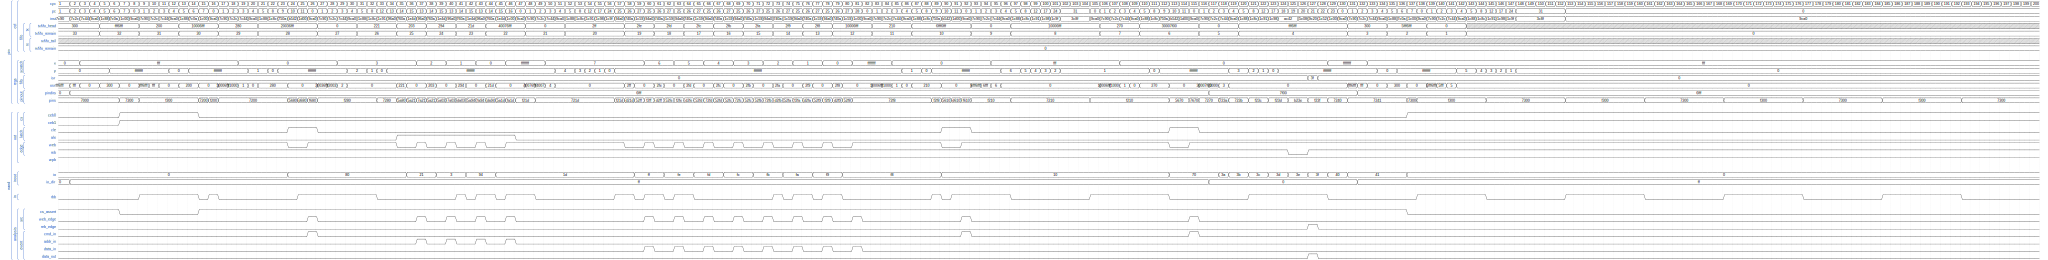

cyc  pc        inst           x           y         isr         osr  \
0      1   1  0x00007C90  0x00000000  0x00000000  0x00000000  0x0FFF6FFF   
1      2   2  0x00007C2C  0x00000000  0x00000000  0x00000000  0x00000FFF   
2      3   3  0x00007C44  0x00000FFF  0x00000000  0x00000000  0x00000000   
3      4   4  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
4      5   5  0x00001C88  0x00000FFF  0x00000000  0x00000000  0x00000300   
..   ...  ..         ...         ...         ...         ...         ...   
195  196   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
196  197   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
197  198   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
198  199   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
199  200   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   

        pindirs        pins          io      io_dir  ceb0  ceb1  cle  ale  \
0    0x00000000  0x00007000  0x00000000  0x00000000     0     0    0    0   
1    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
2    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
3    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
4    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
..          ...         ...         ...         ...   ...   ...  ...  ...   
195  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
196  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
197  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
198  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
199  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   

     wpb  web  reb  rbb txfifo_head  txfifo_remain rxfifo_tail  rxfifo_remain  \
0      1    1    1    0  0x00000300             33        None              0   
1      1    1    1    0  0x00000300             33        None              0   
2      1    1    1    0  0x00000300             33        None              0   
3      1    1    1    0  0x00000300             33        None              0   
4      1    1    1    0  0x0FFF6FFF             32        None              0   
..   ...  ...  ...  ...         ...            ...         ...            ...   
195    1    1    1    0        None              0        None              0   
196    1    1    1    0        None              0        None              0   
197    1    1    1    0        None              0        None              0   
198    1    1    1    0        None              0        None              0   
199    1    1    1    0        None              0        None              0   

     cmd_in  addr_in  data_in  data_out  clock  program_counter  \
0     False    False    False     False      1                1   
1     False    False    False     False      2                2   
2     False    False    False     False      3                3   
3     False    False    False     False      4                4   
4     False    False    False     False      5                5   
..      ...      ...      ...       ...    ...              ...   
195   False    False    False     False    196                0   
196   False    False    False     False    197                0   
197   False    False    False     False    198                0   
198   False    False    False     False    199                0   
199   False    False    False     False    200                0   

     pin_directions  pin_values  \
0                 0       28672   
1             28671       28672   
2             28671       28672   
3             28671       28672   
4             28671       28672   
..              ...         ...   
195           28671       29440   
196           28671       29440   
197           28671       29440   
198           28671       29440   
199 

In [6]:
select_cs = 0
column_addr = 0x321
page_addr = 0x54
block_addr = 0x76
address_list = gen_addressing(column_addr=column_addr, page_addr=page_addr, block_addr=block_addr)
write_bytes = 8  # (実際には2048+128byte単位で使いそう)
data_list = [(~(x & 0xff) & 0xff) for x in range(0, write_bytes)]

print(f"address_list: {to_hex_str_arr(address_list)}")
print(f"data_list: {to_hex_str_arr(data_list)}")

tx_fifo_entries = list(
    itertools.chain.from_iterable(
        [
            #############################################
            ### init pin (=negate cs) ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### assert cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=select_cs)
            ),
            #############################################
            ### CMD: Auto Page Program ###
            # cmd: 0x80
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.AutoPageProgram1stCycle.value, select_cs=select_cs),
            ),
            # addr
            BroccoliNandIoCommand.AddrLatch.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=4, arg0=None
            ),
            bitor_cs(address_list, select_cs=select_cs),
            # data
            BroccoliNandIoCommand.DataInput.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=write_bytes, arg0=None
            ),
            bitor_cs(data_list, select_cs=select_cs), # TODO: 実際にはPIO1を使ってCS ORする?
            # cmd: 0x10
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.AutoPageProgram2ndCycle.value, select_cs=select_cs),
            ),
            #############################################
            ### wait RBB ###
            BroccoliNandIoCommand.WaitRbb.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
            #############################################
            ### Status Read ###
            # cmd: 0x70 (DatasheetのAuto Page Program Operation項のChartだと0x10になっているが多分誤植)
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.StatusRead.value, select_cs=select_cs),
            ),
            # read status output
            BroccoliNandIoCommand.DataOutput.gen_cmd_header(
                pindirs=read_pin_dir, transfer_count=1, arg0=None
            ),
            #############################################
            ### negate cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### set IRQ ###
            BroccoliNandIoCommand.SetIrq.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
        ]
    )
)

ret = sim_broccoli(tx_fifo_entries=tx_fifo_entries, export_file_name="auto_page_program", test_cycles=200, dequeue_period_cyc=4)
# verify
# cmd=autopageprogram1st
assert(ret.event_df.iloc[0]["event"] == "cmd_in")
assert(ret.event_df.iloc[0]["io"] == to_hex_u32(NandFlashCommand.AutoPageProgram1stCycle.value))
assert(ret.event_df.iloc[0]["io_dir"] == to_hex_u32(0xff))
# addr(column2byte+page2byte)
assert(ret.event_df.iloc[1]["event"] == "addr_in")
assert(ret.event_df.iloc[2]["event"] == "addr_in")
assert(ret.event_df.iloc[3]["event"] == "addr_in")
assert(ret.event_df.iloc[4]["event"] == "addr_in")
assert(ret.event_df.iloc[1]["io"] == to_hex_u32(address_list[0]))
assert(ret.event_df.iloc[2]["io"] == to_hex_u32(address_list[1]))
assert(ret.event_df.iloc[3]["io"] == to_hex_u32(address_list[2]))
assert(ret.event_df.iloc[4]["io"] == to_hex_u32(address_list[3]))
assert(ret.event_df.iloc[1]["io_dir"] == to_hex_u32(0xff))
assert(ret.event_df.iloc[2]["io_dir"] == to_hex_u32(0xff))
assert(ret.event_df.iloc[3]["io_dir"] == to_hex_u32(0xff))
assert(ret.event_df.iloc[4]["io_dir"] == to_hex_u32(0xff))
# data input
for i in range(0, write_bytes):
    assert(ret.event_df.iloc[5+i]["event"] == "data_in")
    assert(ret.event_df.iloc[5+i]["io"] == to_hex_u32(data_list[i]))
    assert(ret.event_df.iloc[5+i]["io_dir"] == to_hex_u32(0xff))
# cmd=autopageprogram2nd
assert(ret.event_df.iloc[5+write_bytes]["event"] == "cmd_in")
assert(ret.event_df.iloc[5+write_bytes]["io"] == to_hex_u32(NandFlashCommand.AutoPageProgram2ndCycle.value))
assert(ret.event_df.iloc[5+write_bytes]["io_dir"] == to_hex_u32(0xff))
# cmd=statusread
assert(ret.event_df.iloc[5+write_bytes+1]["event"] == "cmd_in")
assert(ret.event_df.iloc[5+write_bytes+1]["io"] == to_hex_u32(NandFlashCommand.StatusRead.value))
assert(ret.event_df.iloc[5+write_bytes+1]["io_dir"] == to_hex_u32(0xff))
# status output
assert(ret.event_df.iloc[5+write_bytes+2]["event"] == "data_out")
assert(ret.event_df.iloc[5+write_bytes+2]["io_dir"] == to_hex_u32(0x00)) # input
assert(ret.event_df.iloc[5+write_bytes+2]["io"] == to_hex_u32(ret.received_from_rx_fifo[0])) # status output



### Read

address_list: ['0x00000023', '0x00000001', '0x000000C5', '0x00000019']
tx_fifo_entries: 22 ['0x0FFF6FFF', '0x00000300', '0x0FFF6FFF', '0x00000200', '0x10006FFF', '0x00000200', '0x20036FFF', '0x00000000', '0x00000223', '0x00000201', '0x000002C5', '0x00000219', '0x10006FFF', '0x00000230', '0x6FFF6FFF', '0x00000000', '0x30077F00', '0x00000000', '0x0FFF6FFF', '0x00000300', '0x5FFF6FFF', '0x00000000']
received_from_rx_fifo: ['0x0000002A', '0x0000002C', '0x0000002F', '0x00000031', '0x00000034', '0x00000036', '0x00000039', '0x0000003B']
rx_fifo: []


cycle  pc     event  ceb0  ceb1          io      io_dir
0      26   0    cmd_in     0     1  0x00000000  0x000000FF
1      37  13   addr_in     0     1  0x00000023  0x000000FF
2      40  13   addr_in     0     1  0x00000001  0x000000FF
3      43  13   addr_in     0     1  0x000000C5  0x000000FF
4      46  16   addr_in     0     1  0x00000019  0x000000FF
5      57   0    cmd_in     0     1  0x00000030  0x000000FF
6      85  21  data_out     0     1  0x0000002A  0x00000000
7      90  21  data_out     0     1  0x0000002C  0x00000000
8      95  21  data_out     0     1  0x0000002F  0x00000000
9     100  21  data_out     0     1  0x00000031  0x00000000
10    105  21  data_out     0     1  0x00000034  0x00000000
11    110  21  data_out     0     1  0x00000036  0x00000000
12    115  21  data_out     0     1  0x00000039  0x00000000
13    120  21  data_out     0     1  0x0000003B  0x00000000

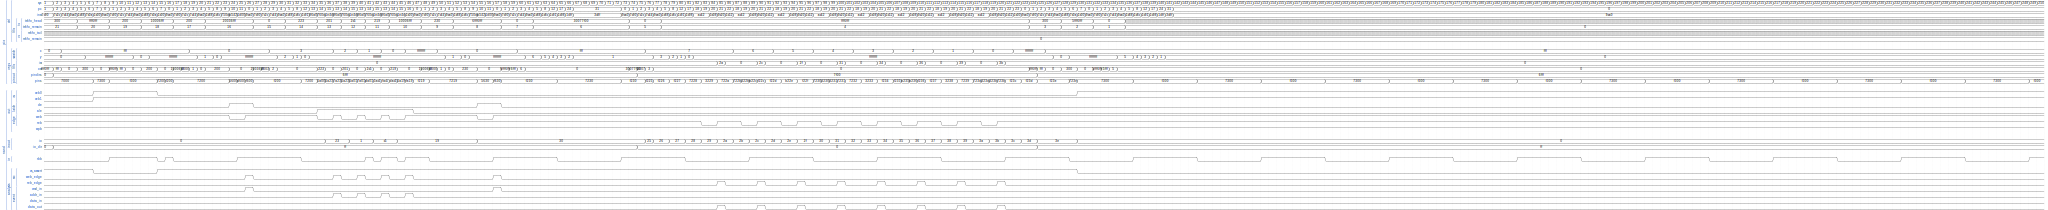

cyc  pc        inst           x           y         isr         osr  \
0      1   1  0x00007C90  0x00000000  0x00000000  0x00000000  0x0FFF6FFF   
1      2   2  0x00007C2C  0x00000000  0x00000000  0x00000000  0x00000FFF   
2      3   3  0x00007C44  0x00000FFF  0x00000000  0x00000000  0x00000000   
3      4   4  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
4      5   5  0x00001C88  0x00000FFF  0x00000000  0x00000000  0x00000300   
..   ...  ..         ...         ...         ...         ...         ...   
245  246   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
246  247   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
247  248   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
248  249   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
249  250   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   

        pindirs        pins          io      io_dir  ceb0  ceb1  cle  ale  \
0    0x00000000  0x00007000  0x00000000  0x00000000     0     0    0    0   
1    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
2    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
3    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
4    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
..          ...         ...         ...         ...   ...   ...  ...  ...   
245  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
246  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
247  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
248  0x00006FFF  0x0000F300  0x00000000  0x000000FF     1     1    0    0   
249  0x00006FFF  0x0000F300  0x00000000  0x000000FF     1     1    0    0   

     wpb  web  reb  rbb txfifo_head  txfifo_remain rxfifo_tail  rxfifo_remain  \
0      1    1    1    0  0x00000300             21        None              0   
1      1    1    1    0  0x00000300             21        None              0   
2      1    1    1    0  0x00000300             21        None              0   
3      1    1    1    0  0x00000300             21        None              0   
4      1    1    1    0  0x0FFF6FFF             20        None              0   
..   ...  ...  ...  ...         ...            ...         ...            ...   
245    1    1    1    0        None              0        None              0   
246    1    1    1    0        None              0        None              0   
247    1    1    1    0        None              0        None              0   
248    1    1    1    1        None              0        None              0   
249    1    1    1    1        None              0        None              0   

     cmd_in  addr_in  data_in  data_out  clock  program_counter  \
0     False    False    False     False      1                1   
1     False    False    False     False      2                2   
2     False    False    False     False      3                3   
3     False    False    False     False      4                4   
4     False    False    False     False      5                5   
..      ...      ...      ...       ...    ...              ...   
245   False    False    False     False    246                0   
246   False    False    False     False    247                0   
247   False    False    False     False    248                0   
248   False    False    False     False    249                0   
249   False    False    False     False    250                0   

     pin_directions  pin_values  \
0                 0       28672   
1             28671       28672   
2             28671       28672   
3             28671       28672   
4             28671       28672   
..              ...         ...   
245           28671       29440   
246           28671       29440   
247           28671       29440   
248           28671       62208   
249 

In [8]:
select_cs = 0
column_addr = 0x123
page_addr = 0x45
block_addr = 0x67
address_list = gen_addressing(column_addr=column_addr, page_addr=page_addr, block_addr=block_addr)
read_bytes = 8  # (実際には2048+128byte単位で使いそう)

print(f"address_list: {to_hex_str_arr(address_list)}")

tx_fifo_entries = list(
    itertools.chain.from_iterable(
        [
            #############################################
            ### init pin (=negate cs) ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### assert cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=select_cs)
            ),
            #############################################
            ### CMD: READ ###
            # cmd: 0x00
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.Read1stCycle.value, select_cs=select_cs),
            ),
            # addr
            BroccoliNandIoCommand.AddrLatch.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=4, arg0=None
            ),
            bitor_cs(address_list, select_cs=select_cs),
            # cmd: 0x30
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.Read2ndCycle.value, select_cs=select_cs),
            ),
            #############################################
            ### wait RBB ###
            BroccoliNandIoCommand.WaitRbb.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
            #############################################
            ### Read ###
            BroccoliNandIoCommand.DataOutput.gen_cmd_header(
                pindirs=read_pin_dir, transfer_count=read_bytes, arg0=None
            ),
            #############################################
            ### negate cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### set IRQ ###
            BroccoliNandIoCommand.SetIrq.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
        ]
    )
)

ret = sim_broccoli(tx_fifo_entries=tx_fifo_entries, export_file_name="read", test_cycles=250, dequeue_period_cyc=4)
## verify
# cmd=read1st
assert(ret.event_df.iloc[0]["event"] == "cmd_in")
assert(ret.event_df.iloc[0]["io"] == to_hex_u32(NandFlashCommand.Read1stCycle.value))
assert(ret.event_df.iloc[0]["io_dir"] == to_hex_u32(0xff))
# # addr(column2byte+page2byte)
assert(ret.event_df.iloc[1]["event"] == "addr_in")
assert(ret.event_df.iloc[2]["event"] == "addr_in")
assert(ret.event_df.iloc[3]["event"] == "addr_in")
assert(ret.event_df.iloc[4]["event"] == "addr_in")
assert(ret.event_df.iloc[1]["io"] == to_hex_u32(address_list[0]))
assert(ret.event_df.iloc[2]["io"] == to_hex_u32(address_list[1]))
assert(ret.event_df.iloc[3]["io"] == to_hex_u32(address_list[2]))
assert(ret.event_df.iloc[4]["io"] == to_hex_u32(address_list[3]))
assert(ret.event_df.iloc[1]["io_dir"] == to_hex_u32(0xff))
assert(ret.event_df.iloc[2]["io_dir"] == to_hex_u32(0xff))
assert(ret.event_df.iloc[3]["io_dir"] == to_hex_u32(0xff))
assert(ret.event_df.iloc[4]["io_dir"] == to_hex_u32(0xff))
# cmd=read2nd
assert(ret.event_df.iloc[5]["event"] == "cmd_in")
assert(ret.event_df.iloc[5]["io"] == to_hex_u32(NandFlashCommand.Read2ndCycle.value))
assert(ret.event_df.iloc[5]["io_dir"] == to_hex_u32(0xff))
# data output
for i in range(0, read_bytes):
    assert(ret.event_df.iloc[6+i]["event"] == "data_out")
    assert(ret.event_df.iloc[6+i]["io_dir"] == to_hex_u32(0x00000000)) # pindir=input
    assert(ret.event_df.iloc[6+i]["io"] == to_hex_u32(ret.received_from_rx_fifo[i])) # rx fifo


### Reset+READ ID

tx_fifo_entries: 17 ['0x0FFF6FFF', '0x00000300', '0x0FFF6FFF', '0x00000200', '0x10006FFF', '0x000002FF', '0x10006FFF', '0x00000290', '0x20006FFF', '0x00000000', '0x00000200', '0x30047F00', '0x00000000', '0x0FFF6FFF', '0x00000300', '0x5FFF6FFF', '0x00000000']
received_from_rx_fifo: ['0x0000001D', '0x00000020', '0x00000022', '0x00000025', '0x00000027']
rx_fifo: []


cycle  pc     event  ceb0  ceb1          io      io_dir
0     26   0    cmd_in     0     1  0x000000FF  0x000000FF
1     36   0    cmd_in     0     1  0x00000090  0x000000FF
2     47  16   addr_in     0     1  0x00000000  0x000000FF
3     60  21  data_out     0     1  0x0000001D  0x00000000
4     65  21  data_out     0     1  0x00000020  0x00000000
5     70  21  data_out     0     1  0x00000022  0x00000000
6     75  21  data_out     0     1  0x00000025  0x00000000
7     80  21  data_out     0     1  0x00000027  0x00000000

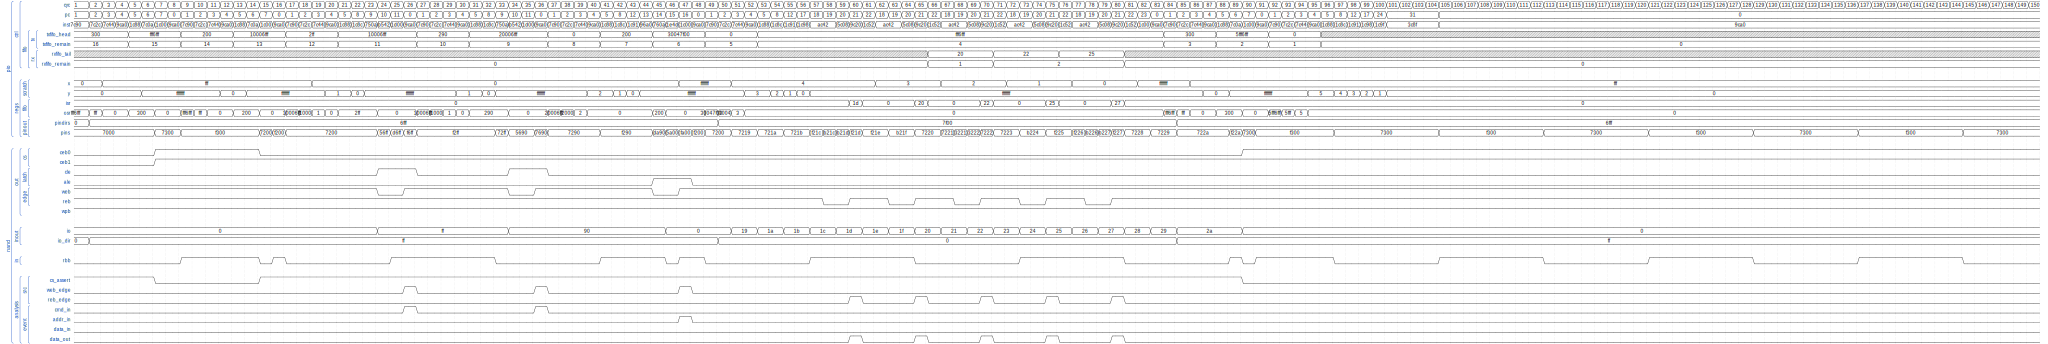

cyc  pc        inst           x           y         isr         osr  \
0      1   1  0x00007C90  0x00000000  0x00000000  0x00000000  0x0FFF6FFF   
1      2   2  0x00007C2C  0x00000000  0x00000000  0x00000000  0x00000FFF   
2      3   3  0x00007C44  0x00000FFF  0x00000000  0x00000000  0x00000000   
3      4   4  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
4      5   5  0x00001C88  0x00000FFF  0x00000000  0x00000000  0x00000300   
..   ...  ..         ...         ...         ...         ...         ...   
145  146   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
146  147   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
147  148   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
148  149   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   
149  150   0  0x00009CA0  0x00000FFF  0x00000000  0x00000000  0x00000000   

        pindirs        pins          io      io_dir  ceb0  ceb1  cle  ale  \
0    0x00000000  0x00007000  0x00000000  0x00000000     0     0    0    0   
1    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
2    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
3    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
4    0x00006FFF  0x00007000  0x00000000  0x000000FF     0     0    0    0   
..          ...         ...         ...         ...   ...   ...  ...  ...   
145  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
146  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
147  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
148  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   
149  0x00006FFF  0x00007300  0x00000000  0x000000FF     1     1    0    0   

     wpb  web  reb  rbb txfifo_head  txfifo_remain rxfifo_tail  rxfifo_remain  \
0      1    1    1    0  0x00000300             16        None              0   
1      1    1    1    0  0x00000300             16        None              0   
2      1    1    1    0  0x00000300             16        None              0   
3      1    1    1    0  0x00000300             16        None              0   
4      1    1    1    0  0x0FFF6FFF             15        None              0   
..   ...  ...  ...  ...         ...            ...         ...            ...   
145    1    1    1    0        None              0        None              0   
146    1    1    1    0        None              0        None              0   
147    1    1    1    0        None              0        None              0   
148    1    1    1    0        None              0        None              0   
149    1    1    1    0        None              0        None              0   

     cmd_in  addr_in  data_in  data_out  clock  program_counter  \
0     False    False    False     False      1                1   
1     False    False    False     False      2                2   
2     False    False    False     False      3                3   
3     False    False    False     False      4                4   
4     False    False    False     False      5                5   
..      ...      ...      ...       ...    ...              ...   
145   False    False    False     False    146                0   
146   False    False    False     False    147                0   
147   False    False    False     False    148                0   
148   False    False    False     False    149                0   
149   False    False    False     False    150                0   

     pin_directions  pin_values  \
0                 0       28672   
1             28671       28672   
2             28671       28672   
3             28671       28672   
4             28671       28672   
..              ...         ...   
145           28671       29440   
146           28671       29440   
147           28671       29440   
148           28671       29440   
149 

In [10]:
select_cs = 0
tx_fifo_entries = list(
    itertools.chain.from_iterable(
        [
            #############################################
            ### init pin (=negate cs) ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### assert cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=select_cs)
            ),
            #############################################
            ### CMD: RESET ###
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.Reset.value, select_cs=select_cs),
            ),
            #############################################
            ### CMD: READ ID ###
            # cmd: 0x90
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.ReadId.value, select_cs=select_cs),
            ),
            # addr=0x00
            BroccoliNandIoCommand.AddrLatch.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=1, arg0=None
            ),
            bitor_cs([0x00000000], select_cs=select_cs),
            #############################################
            ### Read: 5byte ###
            BroccoliNandIoCommand.DataOutput.gen_cmd_header(
                pindirs=read_pin_dir, transfer_count=5, arg0=None
            ),
            #############################################
            ### negate cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### set IRQ ###
            BroccoliNandIoCommand.SetIrq.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
        ]
    )
)

ret = sim_broccoli(tx_fifo_entries=tx_fifo_entries, export_file_name="read_id", test_cycles=150, dequeue_period_cyc=16)

## verify
# reset
assert(ret.event_df.iloc[0]["event"] == "cmd_in")
assert(ret.event_df.iloc[0]["io"] == to_hex_u32(NandFlashCommand.Reset.value))
assert(ret.event_df.iloc[0]["io_dir"] == to_hex_u32(0xff))
# cmd=read id
assert(ret.event_df.iloc[1]["event"] == "cmd_in")
assert(ret.event_df.iloc[1]["io"] == to_hex_u32(NandFlashCommand.ReadId.value))
assert(ret.event_df.iloc[0]["io_dir"] == to_hex_u32(0xff))
# addr=0x00
assert(ret.event_df.iloc[2]["event"] == "addr_in")
assert(ret.event_df.iloc[2]["io"] == to_hex_u32(0x0)) # 0x0固定
assert(ret.event_df.iloc[0]["io_dir"] == to_hex_u32(0xff))
# data output
assert(ret.event_df.iloc[3]["event"] == "data_out")
assert(ret.event_df.iloc[4]["event"] == "data_out")
assert(ret.event_df.iloc[5]["event"] == "data_out")
assert(ret.event_df.iloc[6]["event"] == "data_out")
assert(ret.event_df.iloc[7]["event"] == "data_out")
assert(ret.event_df.iloc[3]["io_dir"] == to_hex_u32(0x00))
assert(ret.event_df.iloc[4]["io_dir"] == to_hex_u32(0x00))
assert(ret.event_df.iloc[5]["io_dir"] == to_hex_u32(0x00))
assert(ret.event_df.iloc[6]["io_dir"] == to_hex_u32(0x00))
assert(ret.event_df.iloc[7]["io_dir"] == to_hex_u32(0x00))
assert(ret.event_df.iloc[3]["io"] == to_hex_u32(ret.received_from_rx_fifo[0]))
assert(ret.event_df.iloc[4]["io"] == to_hex_u32(ret.received_from_rx_fifo[1]))
assert(ret.event_df.iloc[5]["io"] == to_hex_u32(ret.received_from_rx_fifo[2]))
assert(ret.event_df.iloc[6]["io"] == to_hex_u32(ret.received_from_rx_fifo[3]))
assert(ret.event_df.iloc[7]["io"] == to_hex_u32(ret.received_from_rx_fifo[4]))
